arg: in scunet paper they said setting a higher gaussian noise makes it realistic

In [1]:
import os.path
import logging
from PIL import Image

import numpy as np
from datetime import datetime
from collections import OrderedDict

import torch
import time

%load_ext autoreload
%autoreload 2
from utils import utils_logger
from utils import utils_model
from utils import utils_image as util
from SCUNET import SCUNet as net

from IPython.display import display

c:\Users\3aboo\anaconda3\envs\microscopy-service\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [19]:
# Assign default values to variables
model_name = 'scunet_gray_50'
testset_name = 'SEM-Dataset'
noise_level_img = 50
model_zoo = 'model_zoo'
logs_path = 'logs'

In [13]:
def denoise(image:Image):
    # Configuration
    model_name = 'scunet_gray_50'
    testset_name = 'SEM-Dataset'
    noise_level_img = 50
    model_zoo = 'model_zoo'
    logs_path = 'logs'
    n_channels = 1  # Fixed for grayscale images
    
    # Paths and Logger Setup
    model_path = os.path.join(model_zoo, model_name + '.pth')
    result_name = testset_name + '_' + model_name
    logger_name = result_name
    utils_logger.logger_info(logger_name, log_path=os.path.join(logs_path, logger_name + '.log'))
    logger = logging.getLogger(logger_name)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Model Initialization
    model = net(in_nc=n_channels, config=[4, 4, 4, 4, 4, 4, 4], dim=64)
    model = model.to(device)
    logger.info(f'Model path: {model_path}')
    number_parameters = sum(p.numel() for p in model.parameters())
    logger.info(f'Params number: {number_parameters}')

    # Image Preprocessing
    image = image.convert('L')  # Ensure grayscale for single channel
    img_array = np.array(image).astype(np.float32) / 255.0  # Normalize
    img_tensor = torch.from_numpy(img_array).unsqueeze(0).unsqueeze(0).to(device)  # Shape (1, 1, H, W)

    # Denoising
    start_time = time.time()
    with torch.no_grad():
        if img_tensor.size(2) % 8 == 0 and img_tensor.size(3) % 8 == 0:
            img_E = model(img_tensor)
        else:
            img_E = utils_model.test_mode(model, img_tensor, refield=64, mode=5)
    end_time = time.time()
    logger.info(f"Inference time: {end_time - start_time:.4f} seconds")

    # Postprocessing
    img_E = img_E.squeeze(0).squeeze(0).clamp(0, 1).cpu().numpy()  # Shape (H, W)
    img_E = (img_E * 255.0).round().astype(np.uint8)  # Convert to uint8
    img_E_pil = Image.fromarray(img_E, mode='L')  # Convert back to PIL Image (grayscale)

    return img_E

In [72]:
with Image.open('test_images/test_1.png') as image:
    # Image Preprocessing
    image = image.convert('L')  # Ensure grayscale for single channel
    img_array = np.array(image).astype(np.float32) / 255.0  # Normalize
    img_tensor = torch.from_numpy(img_array).unsqueeze(0).unsqueeze(0)  # Shape (1, 1, H, W)

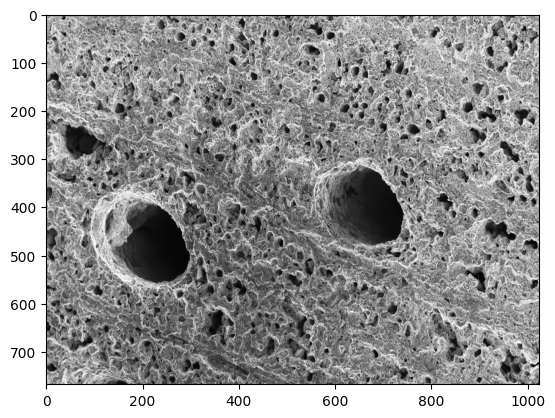

In [74]:
import matplotlib.pyplot as plt
plt.imshow(img_tensor.squeeze(0).squeeze(0), cmap='gray')

In [20]:
n_channels = 1        # fixed, 1 for grayscale image, 3 for color image

border = 0            # shave boader to calculate PSNR and SSIM
model_path = os.path.join(model_zoo, model_name+'.pth')

result_name = testset_name + '_' + model_name
logger_name = result_name
utils_logger.logger_info(logger_name, log_path=os.path.join(logs_path, logger_name+'.log'))
logger = logging.getLogger(logger_name)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

LogHandlers exist!


In [21]:
# ----------------------------------------
# load model
# ----------------------------------------
from SCUNET import SCUNet as net
model = net(in_nc=n_channels,config=[4,4,4,4,4,4,4],dim=64)

Block Initial Type: W, drop_path_rate:0.000000
Block Initial Type: SW, drop_path_rate:0.000000
Block Initial Type: W, drop_path_rate:0.000000
Block Initial Type: SW, drop_path_rate:0.000000
Block Initial Type: W, drop_path_rate:0.000000
Block Initial Type: SW, drop_path_rate:0.000000
Block Initial Type: W, drop_path_rate:0.000000
Block Initial Type: SW, drop_path_rate:0.000000
Block Initial Type: W, drop_path_rate:0.000000
Block Initial Type: SW, drop_path_rate:0.000000
Block Initial Type: W, drop_path_rate:0.000000
Block Initial Type: SW, drop_path_rate:0.000000
Block Initial Type: W, drop_path_rate:0.000000
Block Initial Type: SW, drop_path_rate:0.000000
Block Initial Type: W, drop_path_rate:0.000000
Block Initial Type: SW, drop_path_rate:0.000000
Block Initial Type: W, drop_path_rate:0.000000
Block Initial Type: SW, drop_path_rate:0.000000
Block Initial Type: W, drop_path_rate:0.000000
Block Initial Type: SW, drop_path_rate:0.000000
Block Initial Type: W, drop_path_rate:0.000000
Blo

In [22]:
model.load_state_dict(torch.load(model_path), strict=True)
model.eval()

C:\Users\3aboo\AppData\Local\Temp\ipykernel_19700\1840552217.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path), strict=True)


SCUNet(
  (m_head): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (m_down1): Sequential(
    (0): ConvTransBlock(
      (trans_block): Block(
        (ln1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (msa): WMSA(
          (embedding_layer): Linear(in_features=32, out_features=96, bias=True)
          (linear): Linear(in_features=32, out_features=32, bias=True)
        )
        (drop_path): Identity()
        (ln2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (0): Linear(in_features=32, out_features=128, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=128, out_features=32, bias=True)
        )
      )
      (conv1_1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (conv1_2): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (conv_block): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), pa

In [23]:
model = model.to(device)
logger.info('Model path: {:s}'.format(model_path))
number_parameters = sum(map(lambda x: x.numel(), model.parameters()))
logger.info('Params number: {}'.format(number_parameters))

24-12-13 17:57:11.906 : Model path: model_zoo\scunet_gray_50.pth
24-12-13 17:57:11.909 : Params number: 17943768


In [24]:
logger.info('model_name:{}, image sigma:{}'.format(model_name, noise_level_img))
L_paths = util.get_image_paths('test_images')

num_parameters = sum(map(lambda x: x.numel(), model.parameters()))
logger.info('{:>16s} : {:<.4f} [M]'.format('#Params', num_parameters/10**6))

24-12-13 18:03:02.704 : model_name:scunet_gray_50, image sigma:50
24-12-13 18:03:02.709 :          #Params : 17.9438 [M]


In [47]:
L_paths

['test_images\\test_1.png',
 'test_images\\test_2.png',
 'test_images\\test_3.png',
 'test_images\\test_4.png']

In [77]:
import matplotlib.pyplot as plt
img = L_paths[0]
img_name, ext = os.path.splitext(os.path.basename(img))
img_L = util.imread_uint(img, n_channels=n_channels)


In [78]:
img_L = util.uint2single(img_L)
img_L_tensor = util.single2tensor4(img_L)

In [85]:
test_img = img_L_tensor
test_img[img_L_tensor == img_tensor] = 1

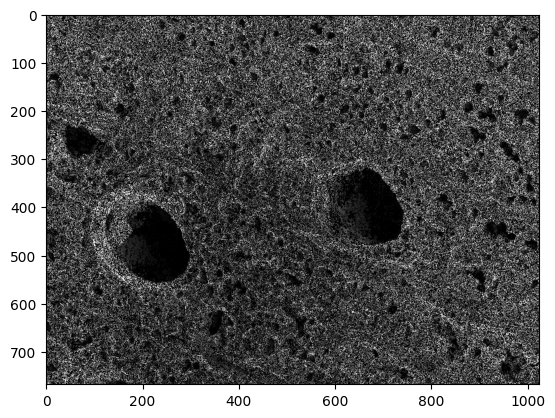

In [86]:
plt.imshow(img_L_tensor.squeeze(0).squeeze(0), cmap='gray')

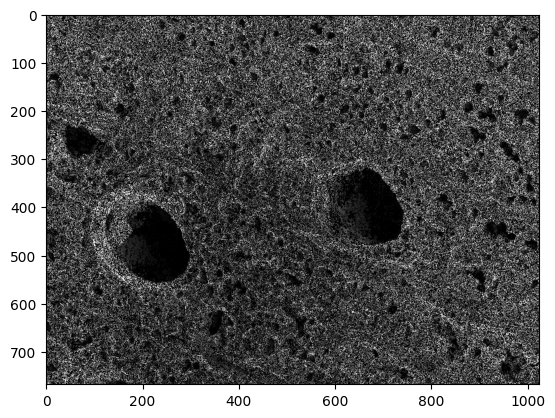

In [87]:
plt.imshow(test_img.squeeze(0).squeeze(0), cmap='gray')

In [65]:
img_L_tensor.shape[2] * img_L_tensor.shape[3]

786432

In [61]:
img_L_tensor[img_L_tensor == img_tensor].shape

torch.Size([428858])

In [30]:
with torch.no_grad():
    img_E = utils_model.test_mode(model, img_L_tensor, refield=64, mode=5)


img_E = util.tensor2uint(img_E)
img_E

array([[179, 151, 143, ..., 190, 157, 142],
       [200, 176, 159, ..., 185, 157, 153],
       [197, 199, 189, ..., 177, 168, 166],
       ...,
       [224, 224, 213, ...,  79,  54,  42],
       [208, 206, 194, ...,  41,  41,  40],
       [188, 182, 172, ...,  38,  40,  40]],
      shape=(768, 1024), dtype=uint8)

In [35]:
img_E.shape

(768, 1024)

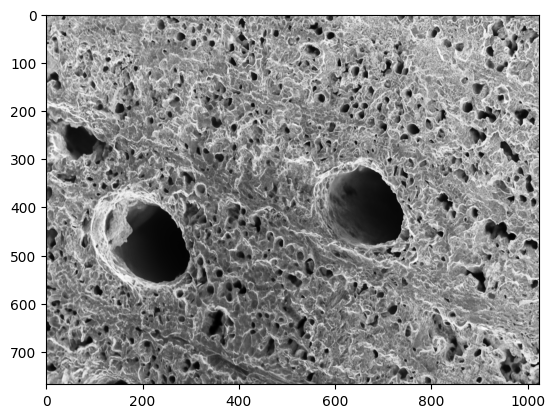

In [33]:
plt.imshow(img_E, cmap='gray')